In [1]:
import sys
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
sys.path.append("..")
from mango.environments import frozen_lake
import utils
import torch
from typing import Any
torch.set_default_device('cuda:0' if torch.cuda.is_available() else 'cpu')

Observation:
 (torch.Size([3, 4, 4]), torch.float32, device(type='cuda', index=0))


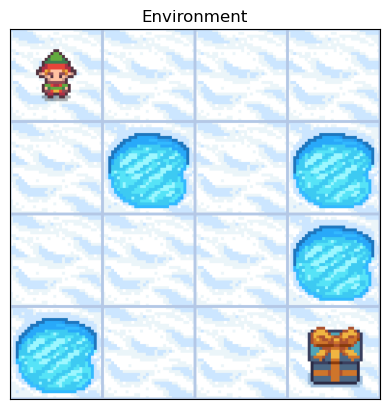

In [2]:
params: dict[str, Any] = dict(map_name="4x4", p=None, shape=(4, 4), seed=42)
env = frozen_lake.wrappers.TensorObservation(
    frozen_lake.wrappers.ReInitOnReset(frozen_lake.CustomFrozenLakeEnv(**params), **params),
    one_hot=True,
)
obs, info = env.reset()
print(f"Observation:\n {obs.shape, obs.dtype, obs.device}")
utils.render(env)

In [8]:
class LazyConvEncoder(torch.nn.Sequential):
    def __init__(self, hidden_channels, out_features):
        layers = []
        for i, channels in enumerate(hidden_channels):
            if i > 0:
                layers.append(torch.nn.LazyBatchNorm2d())
            layers.append(torch.nn.LazyConv2d(channels, 3, padding=1))
            layers.append(torch.nn.GELU())
        layers.append(torch.nn.Flatten())
        layers.append(torch.nn.LazyLinear(out_features))
        super().__init__(*layers)

In [9]:
from mango.mango import MangoEnv, Agent
from mango.policies.experiencereplay import ExperienceReplay
from mango.policies.dqnet import DQNetTrainer, DQNetPolicy

net = LazyConvEncoder(hidden_channels=[8, 8, 8], out_features=int(env.action_space.n)).eval()
policy = DQNetPolicy(net, env.action_space)
trainer = DQNetTrainer(net, lr=1e-3, gamma=0.95)
replay = ExperienceReplay()
agent = Agent(MangoEnv(env), policy)

c:\ProgramData\anaconda3\Lib\site-packages\torch\nn\modules\lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [10]:
import snakeviz
%load_ext snakeviz

In [12]:
%%snakeviz -t
loss_log = []
reward_log = []
eval_reward_log = []


eval_interval = 10
train_steps = 10
for episode in tqdm(range(1000)):
    trans = agent.run_episode(randomness=0.1)
    replay.extend(trans.steps)
    reward_log.append(trans.reward)

    if replay.can_sample():
        for _ in range(train_steps):
            info = trainer.train(replay.sample())
            replay.update_priorities_last_sampled(info.td)
            loss_log.append(info.loss)
    
    if episode % eval_interval == 0:
        trans = agent.run_episode(randomness=0.0)
        eval_reward_log.extend([trans.reward]*eval_interval)       

SyntaxError: invalid syntax (<string>, line 13)

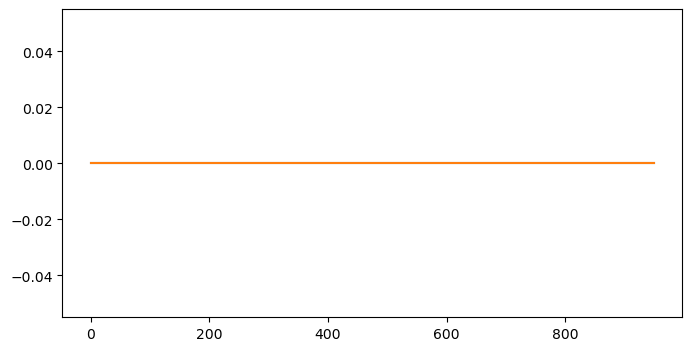

In [ ]:
plt.figure(figsize=(8,4))
plt.plot(utils.smooth(reward_log))
plt.plot(utils.smooth(eval_reward_log))

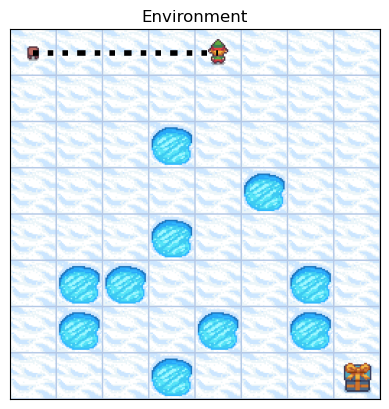

In [ ]:
trans = agent.run_episode(randomness=0.0)
utils.render(env, trajectory=trans.trajectory)